In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

import scipy.optimize as opt
from scipy.integrate import odeint, quad
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

from pathlib import Path
import os
import sys
from byutpl.properties import water as water


# ----- Constants ----- #
# heat exchanger physical parameters
di = .206 * 2.54 / 100                  # m
do = .25 * 2.54 / 100                   # m
L = 14 * 2.54 / 100                     # m
k = 16.3                                # W/m.K 316 SS
g = 9.81                                # m/s^2
N = 56                                  # number of tubes    

# calculate the heat transfer area
# Ai = .25 * np.pi * di**2 * N
# Ao = .25 * np.pi * do**2 * N
Ai = np.pi * di * N * L
Ao = np.pi * do * N * L

# ---------------------------------------------- Functions ---------------------------------------------- #
# ----- Functions ----- #
def hi(Qi,Ti):
    # calculate the velocity
    Ac = np.pi * di**2 * .25 * N
    v = Qi / Ac

    # calculate the Reynolds number
    Re = water.ldn(Ti) * v * di / water.lvs(Ti)

    # calculate the Nusselt number
    if Re < 10000:
        Nu = 3.66
    else:
        Nu = .023 * (Re**.8) * water.lpr(Ti)**.4

    # calculate heat transfer coefficient
    h = Nu * water.ltc(Ti) / di
    return h

def ho(Ps,Ts):
    # pull in the values
    rhol = water.ldn(Ts)
    rhov = water.vdn(Ts,Ps)
    kl = water.ltc(Ts)
    mul = water.lvs(Ts)
    Tsat = water.tsat(Ps)
    cpl = water.vcp(Ts,Ps) / water.mw
    # cpl = water.lcp(Ts) / water.mw
    hfg = water.hvp(Ts) / water.mw

    # find Ja
    Ja = cpl * (Tsat - Ts) / hfg

    # calculate the condensation energy
    hfp = hfg * (1 + (.68 * Ja))

    # calculate the heat transfer coefficient
    h = .729 * ( (rhol * g * (rhol - rhov) * hfp * kl**3) / (N * mul * (Tsat - Ts) * do))**.25
    return h

hi_vec = np.vectorize(hi)
ho_vec = np.vectorize(ho)


def model(inputs,Rf):
    Qwd,Psd,Tweffd = inputs

    #                                  |               |                                        |
    #      convection_inner            | fouling_inner |               conduction               | convection_outer
    #                                  |               |                                        |
    sumR = (hi_vec(Qwd, Tweffd) * Ai)**-1 + (Rf / Ai) + (np.log(do / di) / (2 * np.pi * k * L * N)) + (ho_vec(Psd, Tweffd) * Ao)**-1
    # sumR = .1 + (Rf / Ai) + (np.log(do / di) / (2 * np.pi * k * L * N)) + (ho_vec(Psd, Tweffd) * Ao)**-1
    # print(((hi_vec(Qwd, Tweffd) * Ai)**-1)[0], (Rf / Ai), (np.log(do / di) / (2 * np.pi * k * L * N)), ((ho_vec(Psd, Tweffd) * Ao)**-1)[0])
    UA = 1 / sumR
    return UA



# ---------------------------------------------- Import Data ---------------------------------------------- #
data1 = pd.read_csv('data/Trial1.csv')
data2 = pd.read_csv('data/Trial2.csv')
data3 = pd.read_csv('data/Trial3.csv')
data4 = pd.read_csv('data/Trial4.csv')
data5 = pd.read_csv('data/Trial5.csv')
data6 = pd.read_csv('data/Trial6.csv')
data7 = pd.read_csv('data/Trial7.csv')
data8 = pd.read_csv('data/Trial8.csv')
data9 = pd.read_csv('data/Trial9.csv')
dataA = pd.read_csv('data/TrialA.csv')
dataB = pd.read_csv('data/TrialB.csv')
dataC = pd.read_csv('data/TrialC.csv')
#dataD = pd.read_csv('data/TrialD.csv')
#dataE = pd.read_csv('data/TrialE.csv')

# data_collection =                 np.array([data4,data5,data6,data7,data8,data9,dataA,dataB,dataC])
data_collection = np.array([data1,data2,data3,data4,data5,data6,data7,data8,data9,dataA,dataB,dataC])

#print(data4.keys())


qs = np.array([])
Twout = np.array([])
Twin = np.array([])
Ps = np.array([])

# create the data arrays
for i, df in enumerate(data_collection):
    qs = np.append(qs,df[:,2])
    Twout = np.append(Twout,df[:,6])
    Twin = np.append(Twin,df[:,5])
    Ps = np.append(Ps,df[:,4])
    
Tavg = (Twout + Twin) / 2

# conver the data to SI units
qs_good = qs * .003785 / 60                 # gal/min to m^3/s
Ps_good = (Ps + 14.7) * 101325 / 14.7       # psig to Pa
Cpw = water.lcp(Tavg + 273.15) / water.mw   # J/kg.K

tsat = np.vectorize(water.tsat)

Tsat = tsat(Ps_good)

# ---------------------------------------------- Calculations ---------------------------------------------- #
# calculate the delta T values
dT1 = Tsat - Twout
dT2 = Tsat - Twin

# calcualate the delta T log mean
dTlm = (dT1 - dT2) / np.log(dT1 / dT2)

# calculate the mass flow rate of the water 
rho = water.ldn(Tavg + 273.15)
m = qs_good * rho

# find the heat transfer
Q = -m * Cpw * (Twin - Twout)

# calculate the heat transfer coefficient
UA_array = Q / dTlm


# # fit the data with the model
# Rf = curve_fit(model, (qs_good,Ps_good,Tavg + 273.15), UA)

xdata = np.array([qs_good, Ps_good, Tavg + 273.15])  # Stack inputs correctly

# print(xdata)
Rf, _ = curve_fit(model, xdata, UA_array)
Rf = Rf[0]

print(f"Rf = {Rf:.6f} m2K/W")


# ---------------------------------------------- Plotting ---------------------------------------------- #
# Create a 3D mesh grid for flow rate and pressure
flow_rate_range = np.linspace(min(qs_good), max(qs_good),100)
pressure_range = np.linspace(min(Ps_good), max(Ps_good), 100)
flow_rate_mesh, pressure_mesh = np.meshgrid(flow_rate_range, pressure_range)

# Calculate the UA coefficient for each point in the mesh grid using the fit function
temperature_avg = np.mean(Tavg + 273.15)
UA_mesh = model((flow_rate_mesh, pressure_mesh, temperature_avg),Rf)

# Plot the 3D surface of the UA coefficient
#ig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(flow_rate_mesh * 1000, pressure_mesh / 101325, UA_mesh, cmap='viridis')
#
#ax.scatter(qs_good * 1000, Ps_good / 101325, UA_array, color = '#ff9933', label='Data Points', s = 1)
#
#ax.set_xlabel('Flow Rate (L/s)')
#ax.set_ylabel('Pressure (atm)')
#ax.set_zlabel('UA Coefficient (W/K)')
#ax.set_title('UA Coefficient as a Function of Flow Rate and Pressure')
#plt.show()

# Plot the fit function with the minimized Rf value
UA_fit = model((qs_good, Ps_good, Tavg + 273.15), Rf)

#plt.figure()
#plt.plot(UA_array, label='Actual UA')
#plt.plot(UA_fit, label='Fitted UA')
#plt.xlabel('Data Points')
#plt.ylabel('UA Coefficient (W/K)')
#plt.legend()
#plt.title('Actual vs Fitted UA Coefficient')
# plt.show()

Rf = 0.001267 m2K/W


## Establish a Dictionary of HX Parameters from Standard Xchange List

In [3]:
# Function using determined fouling factor
# Dictionary of parameters for HX Options

#           Num of Tubes, Di (in),  Do (in),   Length of tubes (in)
HXs = {
    "02008": {"N": 28,  "di": 0.206, "do": 0.250, "L": 8},
    "02014": {"N": 28,  "di": 0.206, "do": 0.250, "L": 14},
    
    "03008": {"N": 56,  "di": 0.206, "do": 0.250, "L": 8},
    "03014": {"N": 56,  "di": 0.206, "do": 0.250, "L": 14},
    "03024": {"N": 56,  "di": 0.206, "do": 0.250, "L": 24},
    "03036": {"N": 56,  "di": 0.206, "do": 0.250, "L": 36},

    "04014": {"N": 108, "di": 0.206, "do": 0.250, "L": 14},
    "04024": {"N": 108, "di": 0.206, "do": 0.250, "L": 24},
    "04036": {"N": 108, "di": 0.206, "do": 0.250, "L": 36},

    "05014": {"N": 80,  "di": 0.331, "do": 0.375, "L": 14},
    "05024": {"N": 80,  "di": 0.331, "do": 0.375, "L": 24},
    "05036": {"N": 80,  "di": 0.331, "do": 0.375, "L": 36},

    "06024": {"N": 116, "di": 0.331, "do": 0.375, "L": 24},
    "06036": {"N": 116, "di": 0.331, "do": 0.375, "L": 36},
    "06048": {"N": 116, "di": 0.331, "do": 0.375, "L": 48},

    "08024": {"N": 210, "di": 0.331, "do": 0.375, "L": 24},
    "08036": {"N": 210, "di": 0.331, "do": 0.375, "L": 36},
    "08048": {"N": 210, "di": 0.331, "do": 0.375, "L": 48},
    "08060": {"N": 210, "di": 0.331, "do": 0.375, "L": 60},
    "08072": {"N": 210, "di": 0.331, "do": 0.375, "L": 72},
    "08084": {"N": 210, "di": 0.331, "do": 0.375, "L": 84},
    "08096": {"N": 210, "di": 0.331, "do": 0.375, "L": 96}
}

In [4]:
print(HXs["03014"])

{'N': 56, 'di': 0.206, 'do': 0.25, 'L': 14}


## Create a Function to Find the Outlet Temperature Given our Choice of HX

In [6]:
def HXLIST(hx):
    '''Input a heat exchanger from the list, it returns an output temperature for the system at scale'''
    '''fsolve this function for Tout. It will give the first half of equation 2, or UA * ΔTlm'''
    N  = HXs[hx]['N']   # Number of tubes
    di = HXs[hx]['di'] * 2.54 / 100 # Inner diameter of tubes (inches-> m)
    do = HXs[hx]['do'] * 2.54 / 100 # Outer diameter of tubes (inches-> m)
    L  = HXs[hx]['L']  * 2.54 / 100  # Length of tubes (inches -> m)
    #print(N,di,do,L)
    
    # calculate the heat transfer area
    Ai = np.pi * di * L * N # inner circumference * tube length
    Ao = np.pi * do * L * N # outer circumference * tube length
    
    # Conditions at scale
    Q    = 200 * 6.30902e-5 # gal/min -> m3/s
    #Q = 25*6.30902e-5  # Lab conditions
    Tin  = 25 + 273   # degC -> K
    psig = 300   # EDIT THIS DEPENDING ON HX PERFORMANCE. CAN BE UP TO 300 BUT SHOULD BE LOWER
    #psig = 30     # Lab conditions
    Pressure = (psig + 14.7) * (101325 / 14.7) # psig -> Pa
    k_ss316 = 13.4    # W/m K
    g = 9.81          # m/s2
    Rfi = Rf      # 0.001267 m2K/W, as of 2/24
    
    Tsat = water.tsat(Pressure) # fill in later
    
    def UATlm(Tout): # Tout in K
        '''This function will need to calculate UA using equations 1, 3-6'''
        Tavg = (Tin + Tout)/2

        ν    = water.lnu(Tavg)    # kinematic viscosity m2/s
        μl = water.lvs(Tavg)
        ρH2O = water.ldn(Tavg)    # density  kg/m3
        ρsteam = water.vdn(Tavg,Pressure)
        kf   = water.ltc(Tavg)    # thermal conductivity in W/mK
        Pr   = water.lpr(Tavg)    # Prandtl number
        Cp = water.lcp(Tavg) / 0.01802   # J/mol K -> J/kg K

        Ac = np.pi*di**2/4   # Cross sectional area 
        
        q_per_tube = Q/N         # m3/s
        veloc = q_per_tube/Ac    # m3/s  /  m2 -> m/s
        
        Re =  ρH2O*veloc*di/μl   # density * velocity * inner diameter / dynamic viscosity
        #print(f"Re = {float(Re):.0f}")
        
        if Re <= 2300:
            '''Laminar'''
            Nu = 3.66
        else:
            '''Turbulent'''
            '''Equation 4'''
            n = 0.4 # for heating
            Nu = 0.023*(Re**0.8)*(Pr**n)

        '''Equation 3'''
        hi = Nu*kf/di

        '''Equation 6'''
        hfg = water.hvp(Tavg) / water.mw
        Ja = Cp * (Tsat - Tavg) / hfg      # Tavg = Ts?
        hfp = hfg * (1 + (.68 * Ja))
        
        '''Equation 5'''
        numer = ρH2O * g * (ρH2O - ρsteam) * hfp * kf**3
        denom = N * μl * (Tsat - Tavg) * do      # Tavg = Ts?
        ho = .729 * (numer/denom)**(1/4)

        '''Equation 1'''
        R_conv_in  = 1/hi/Ai
        R_conv_out = 1/ho/Ao
        R_cond     = np.log(do/di)/2/np.pi/k_ss316/L/N
        R_fouling  = Rfi / Ai
        #print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~\nLeft hand side of EQ 2:")
        #print(f"R_ci = {R_conv_in}\nR_co = {R_conv_out}\nR_cd = {R_cond}\nR_f = {R_fouling}")     # Uncomment for Debugging
        
        UA = 1/ (R_conv_in + R_fouling + R_cond + R_conv_out) 
        #UA = 200  What 
        
        ΔT1  = Tsat - Tout
        ΔT2  = Tsat - Tin
        ΔTlm = (ΔT1-ΔT2)/(np.log(ΔT1)-np.log(ΔT2))
        #print(f"UA = {UA} W/K\nTsat = {Tsat:.1f} K\nΔTlm = {ΔTlm} K\n")
        
        return UA * ΔTlm        # returns a q value in W

    def Q_func(Tout):           # Tout in K
        '''This function is good to go'''
        Tavg = (Tin + Tout)/2
        ρH2O = water.ldn(Tavg)  # in kg/m3, Tavg in K
        mdot = Q*ρH2O           # kg/s
        Cp = water.lcp(Tavg) / 0.01802   # J/mol K -> J/kg K
        #print(f"Right hand side of EQ 2:\nmdot = {mdot} kg/s\nCp = {Cp} J/kg/K\nΔT = {Tin - Tout}K\n")
        return - mdot * Cp * (Tin - Tout) # returns a q value in W

    # Solve Equation 2 for outlet temperature
    TOUT = fsolve(lambda T: UATlm(T) - Q_func(T),75+273)[0] - 273 # returns outlet temp in C
    
    return TOUT

print(f"03014: T_out = {HXLIST("03014"):.5f} °C")
#print(f"05024: T_out = {HXLIST("05024"):.5f} °C")
#print(f"08096: T_out = {HXLIST("08096"):.5f} °C")

03014: T_out = 25.64896 °C


# Use Function to Evaluate HX Options
It should be 75°C

In [8]:
Results = np.zeros(len(HXs))
for key, value in enumerate(HXs.items()):
    Results[key] = HXLIST(value[0])

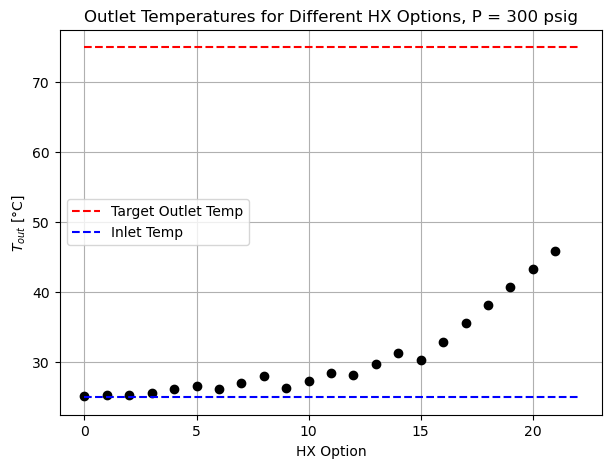

In [9]:
plt.figure(figsize=(7,5))
plt.title("Outlet Temperatures for Different HX Options, P = 300 psig")
plt.plot(Results,'ko')
plt.plot([0,22],[75,75],'r--',label="Target Outlet Temp")
plt.plot([0,22],[25,25],'b--',label="Inlet Temp")
plt.ylabel(r"$T_{out}$ [°C]")
plt.xlabel("HX Option")
plt.grid()
plt.legend(loc="center left")
plt.show();